# 1. Importing and preparing data

In [1]:
!pip install scanpy scipy umap-learn leidenalg
#!pip install git+https://github.com/pcahan1/PySingleCellNet/
#!pip install scikit-misc
#!pip install -U scFates
#!pip install -q git+https://github.com/theislab/cellrank
#!pip install git+https://github.com/CahanLab/oneSC.git
!pip install requests

#import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
#import pySingleCellNet as cn
#import skmisc
#import scFates as scf
#import scvelo as scv
#import cellrank as cr
#import onesc
#import networkx as nx
import warnings
import requests

#os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"
#cr.settings.verbosity = 2
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300

  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached anndata-0.11.4-py3-none-any.whl.metadata (9.3 kB)
  Using cached legacy_api_wrap-1.4.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached session_info2-0.1.2-py3-none-any.whl.metadata (2.5 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached igra

In [ ]:
# LaTeX supplement for matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 16,
    "font.size": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.latex.preamble": r"\usepackage{amsmath,amssymb}"
})

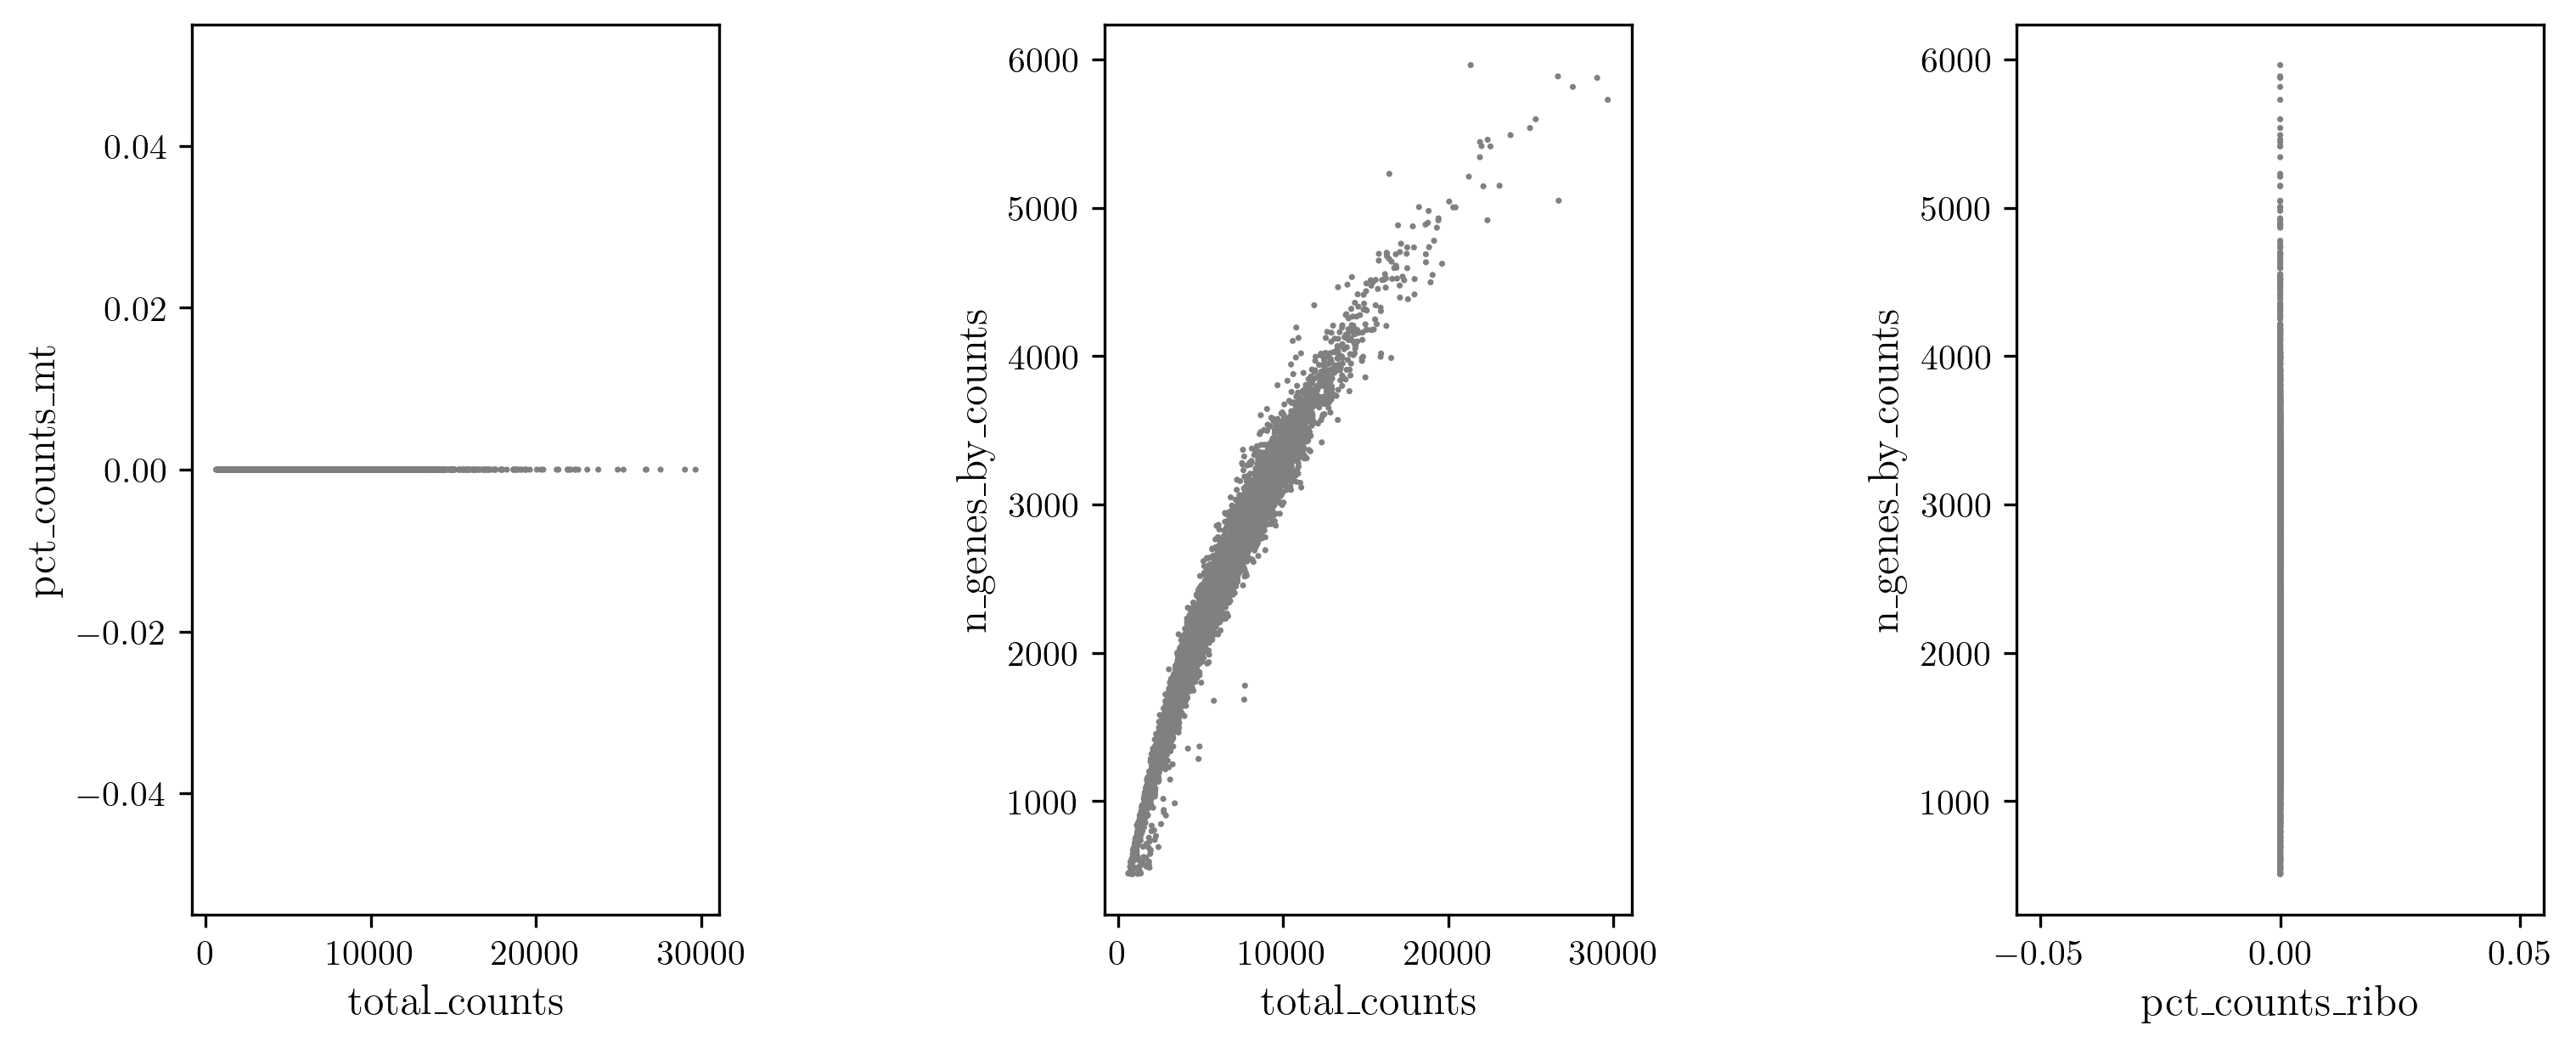

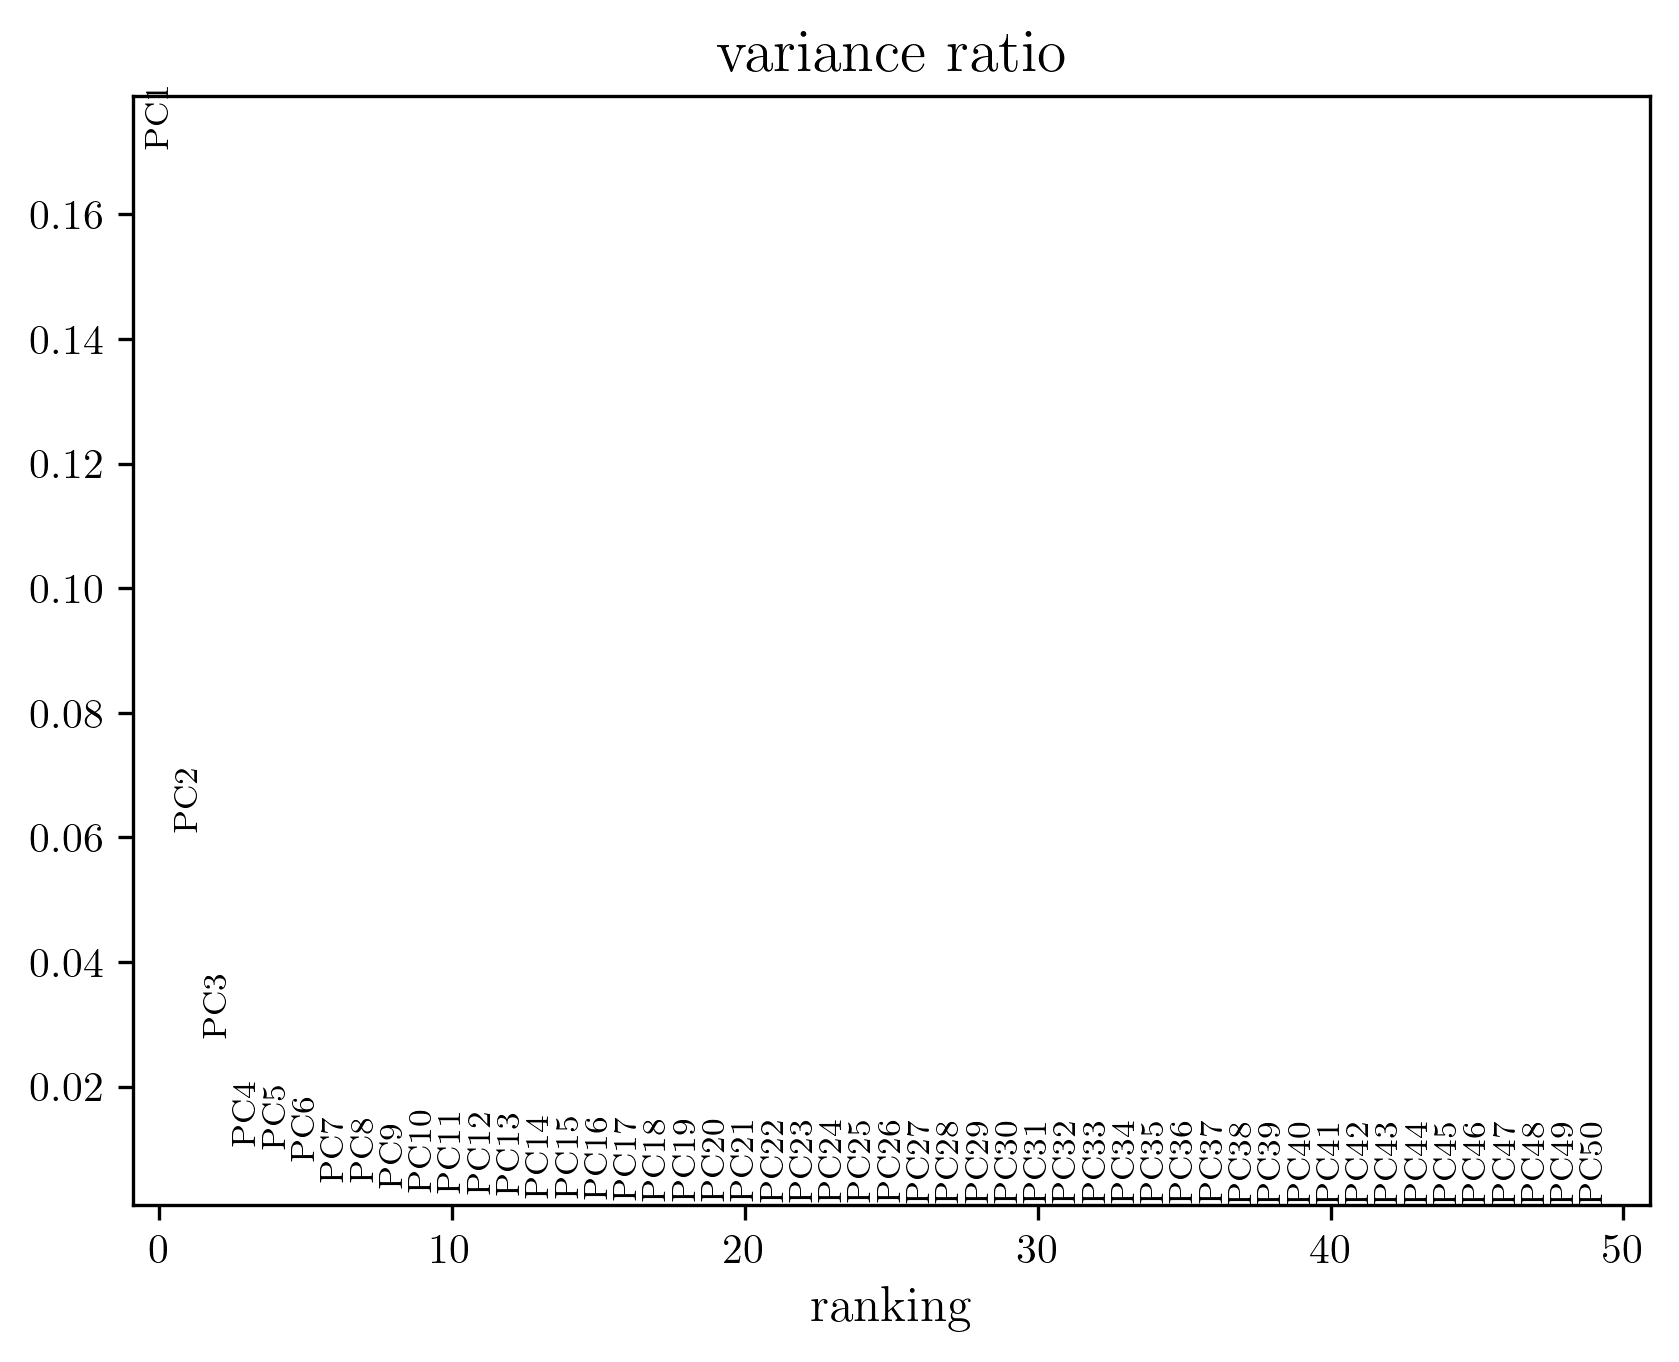

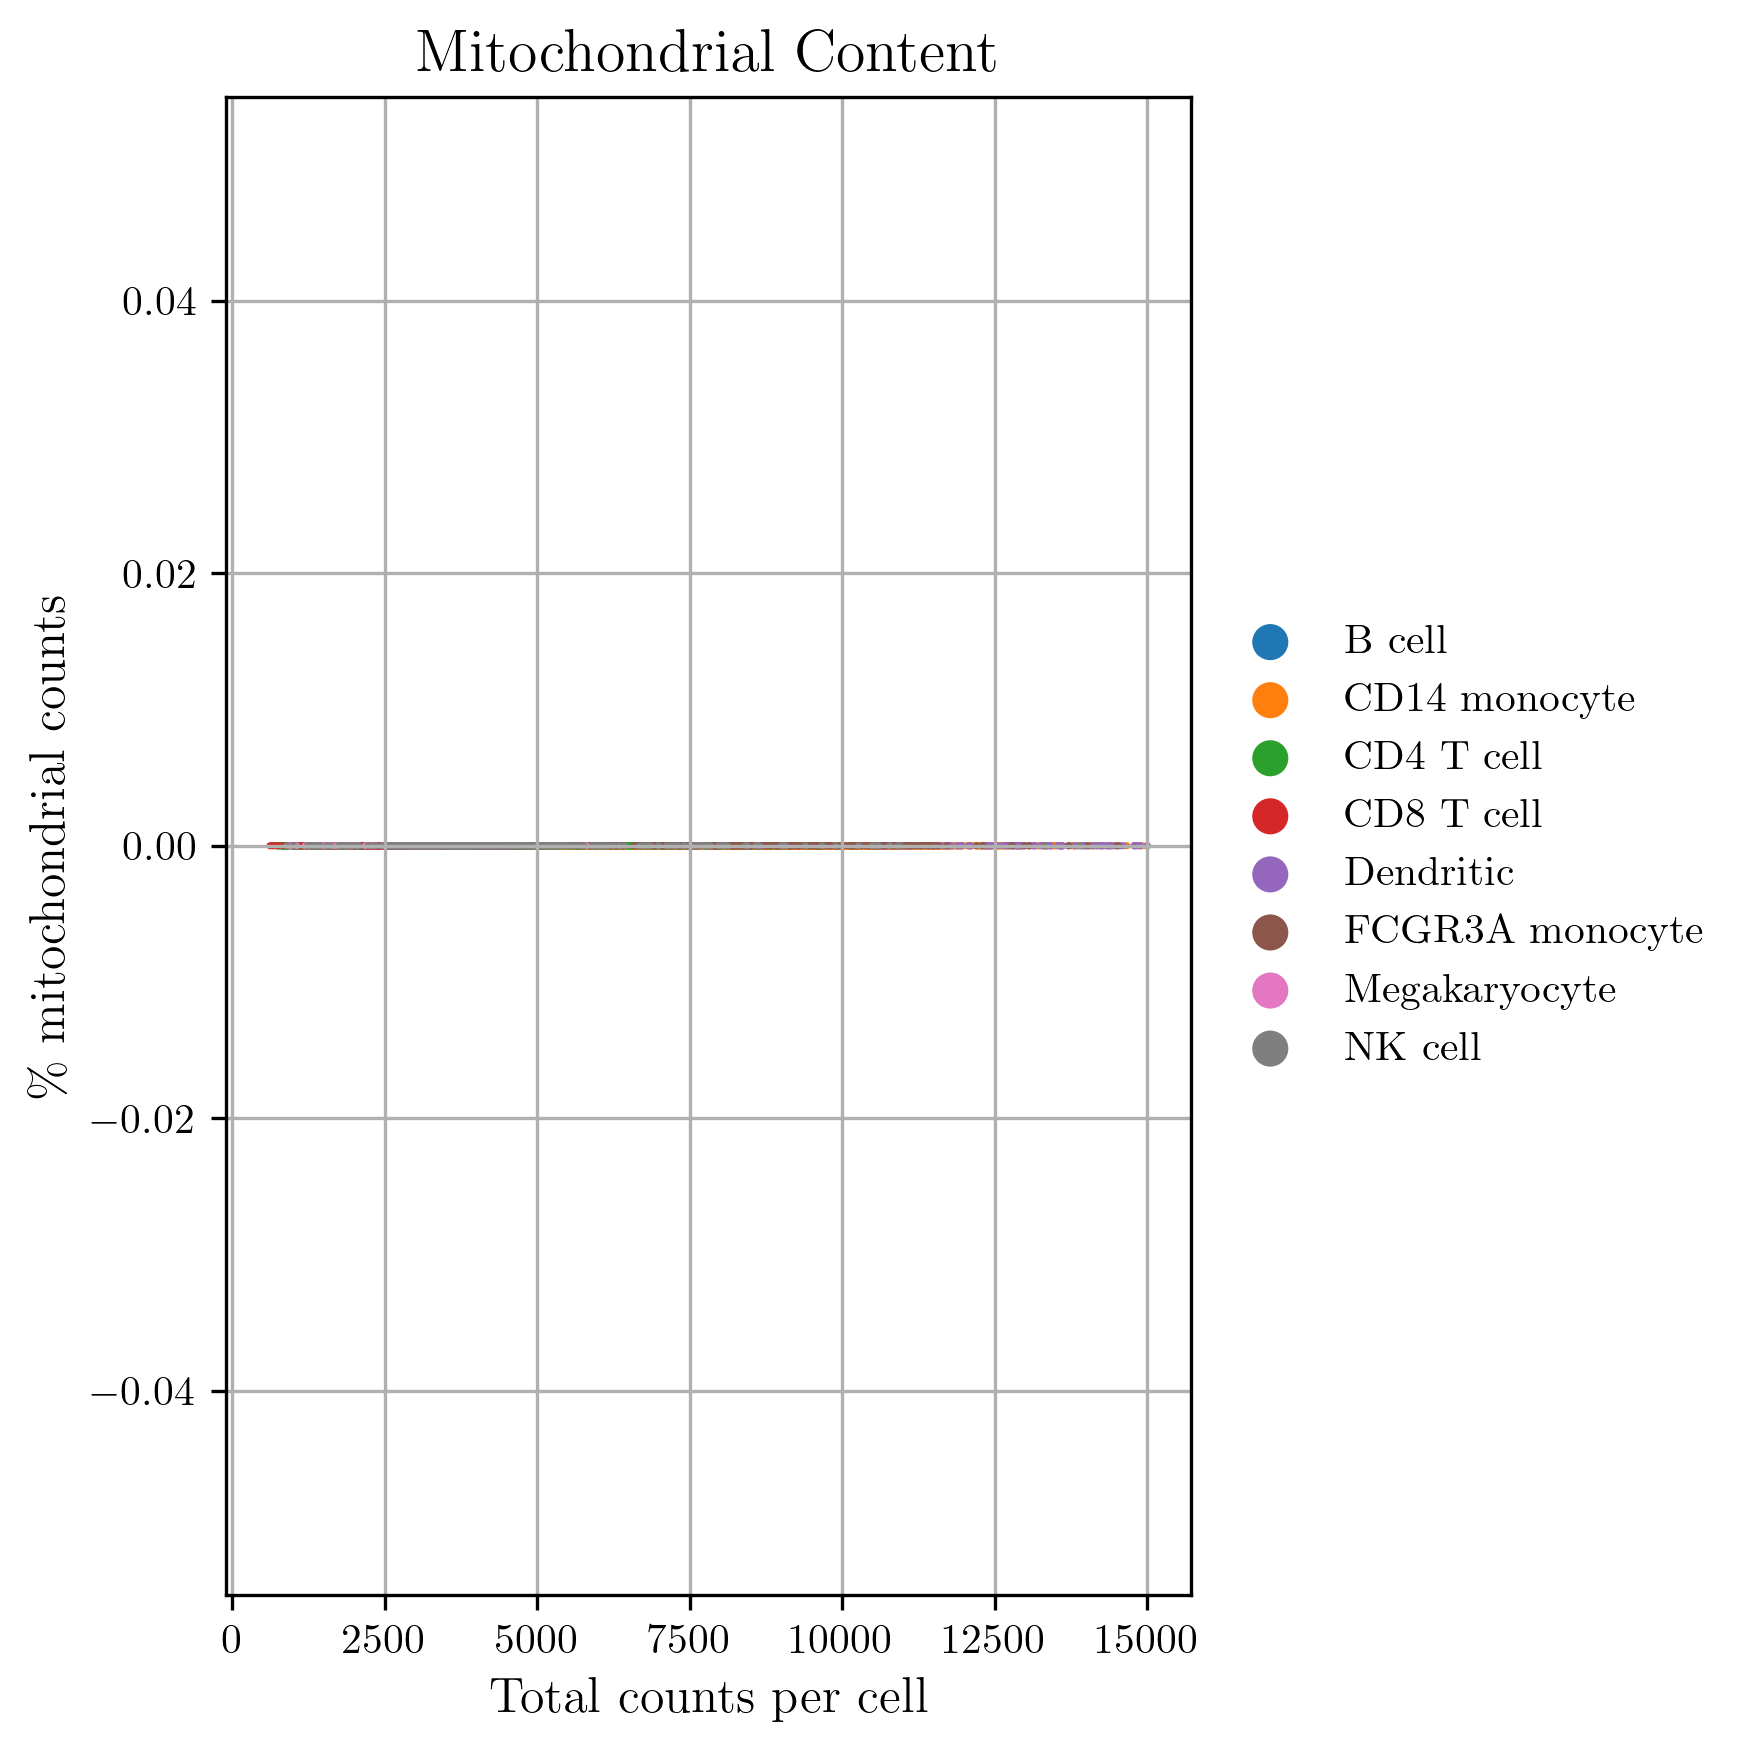

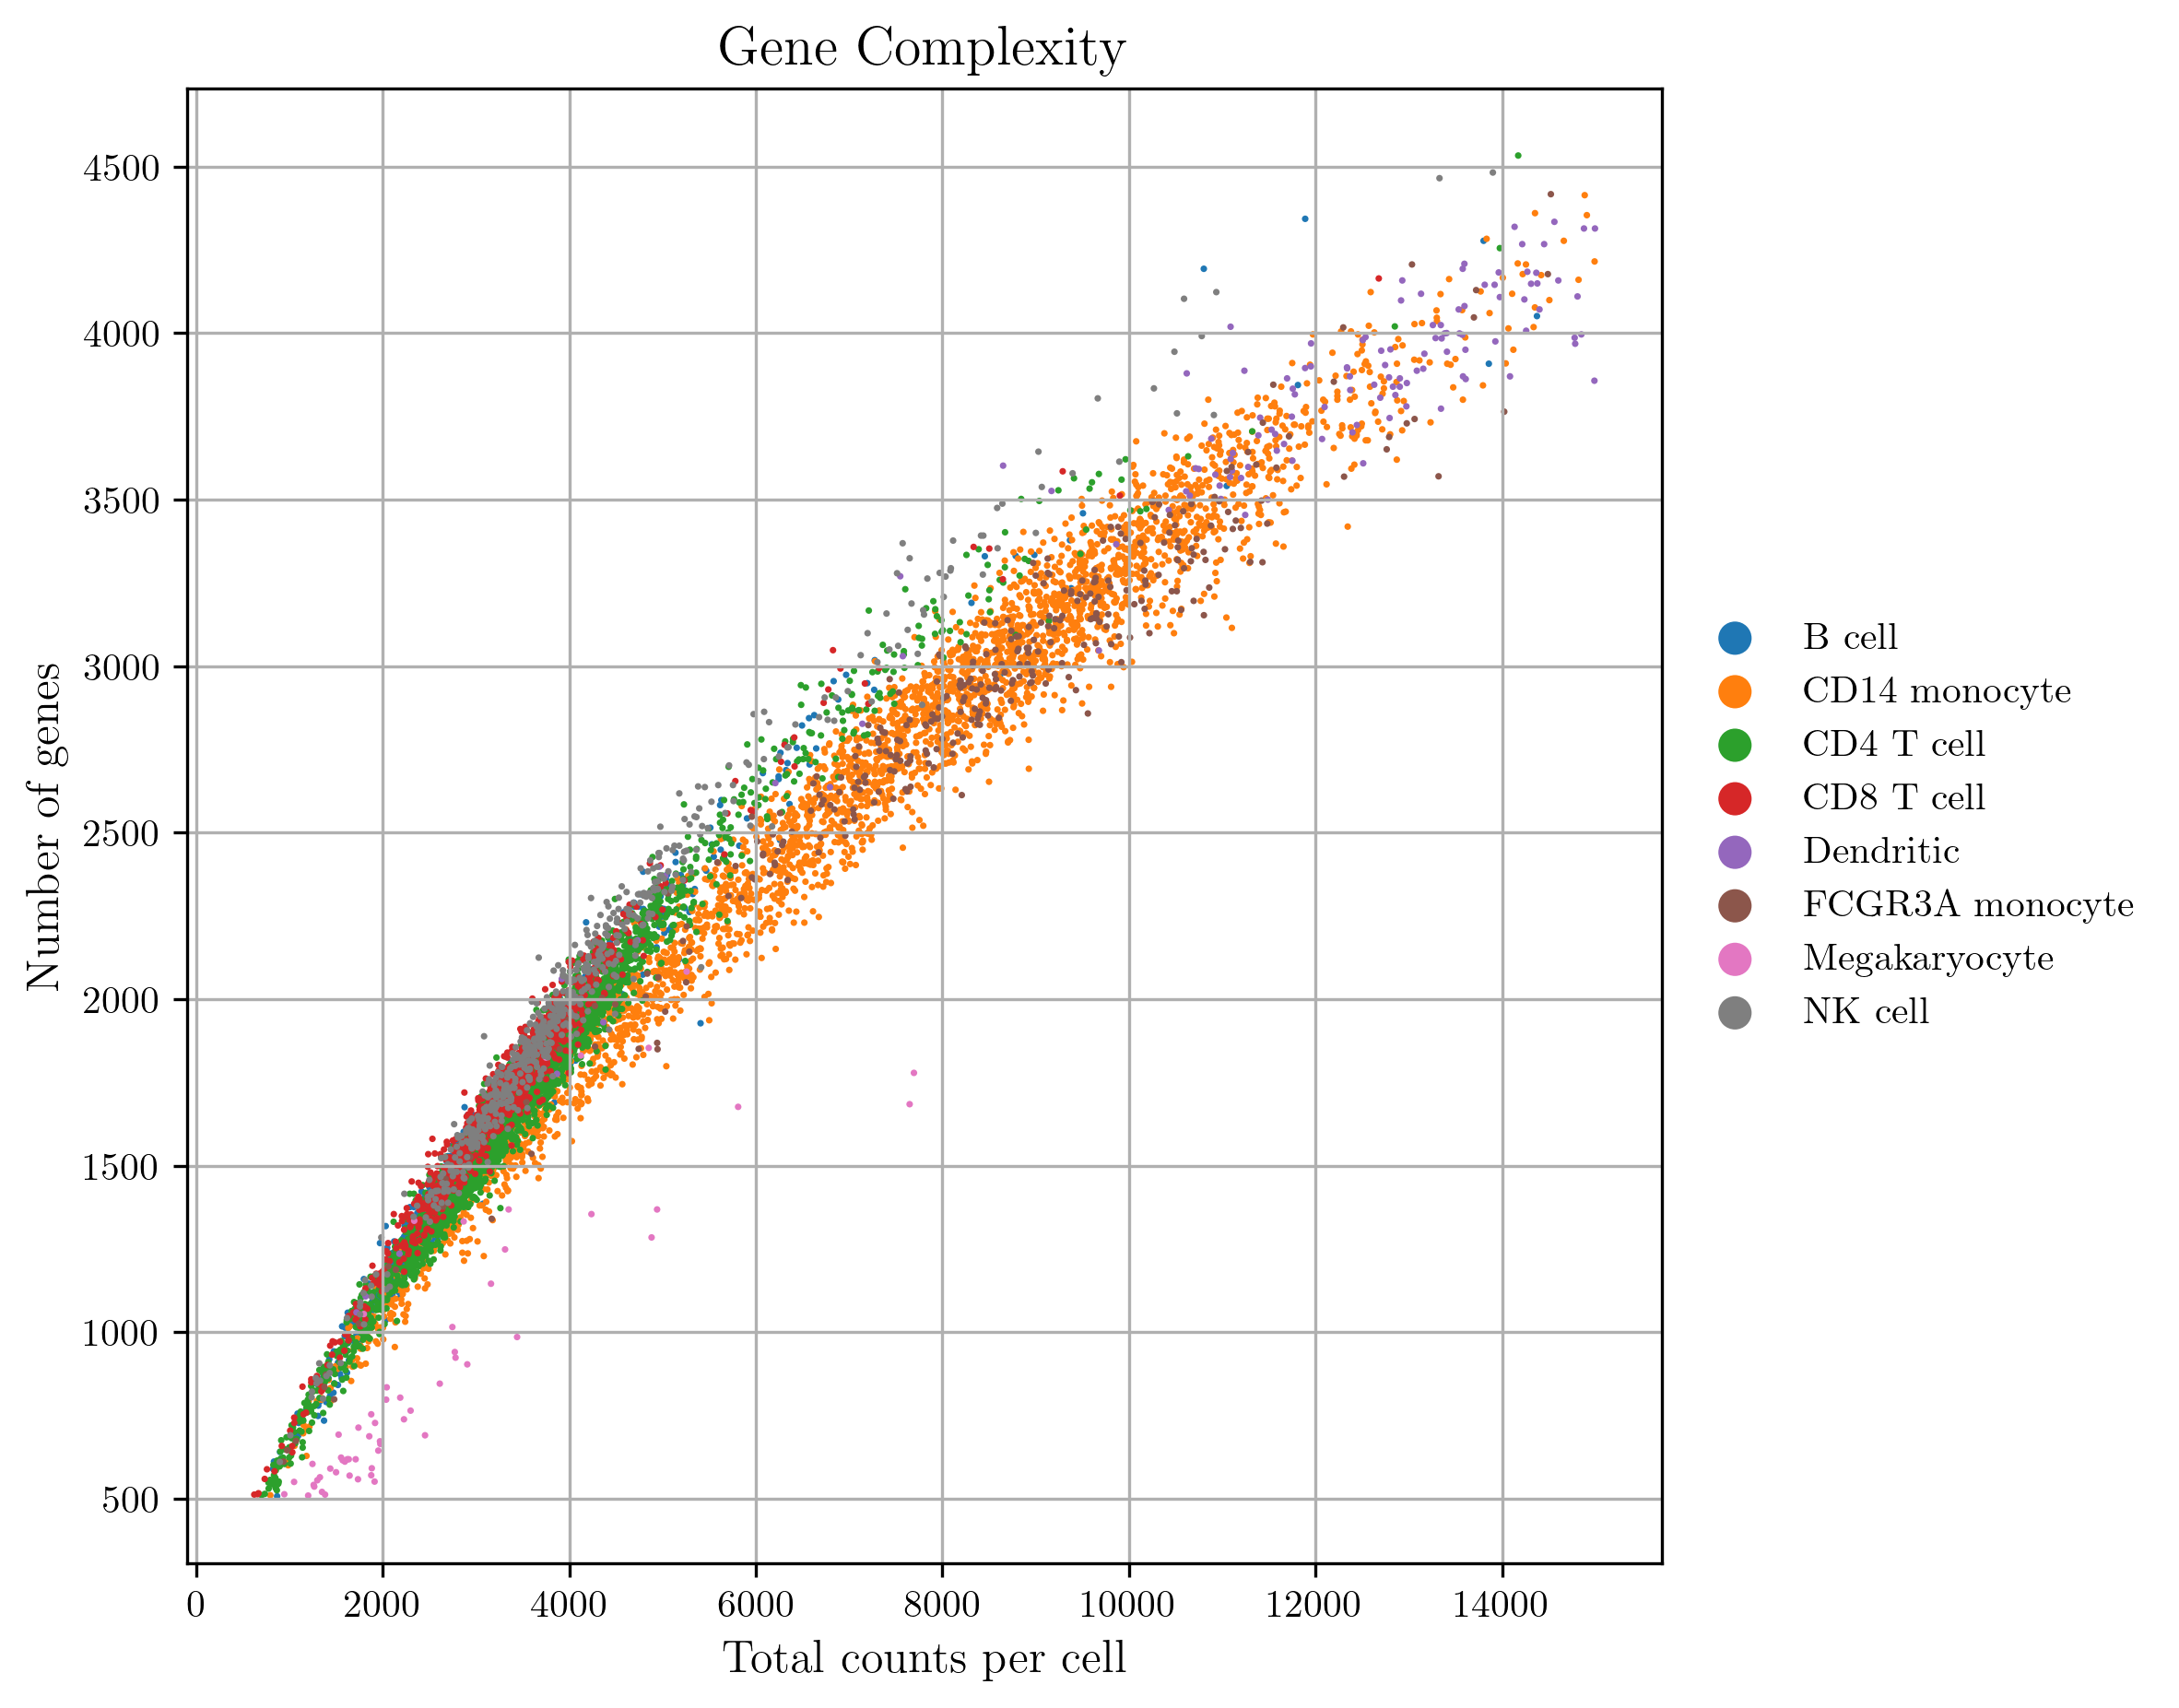

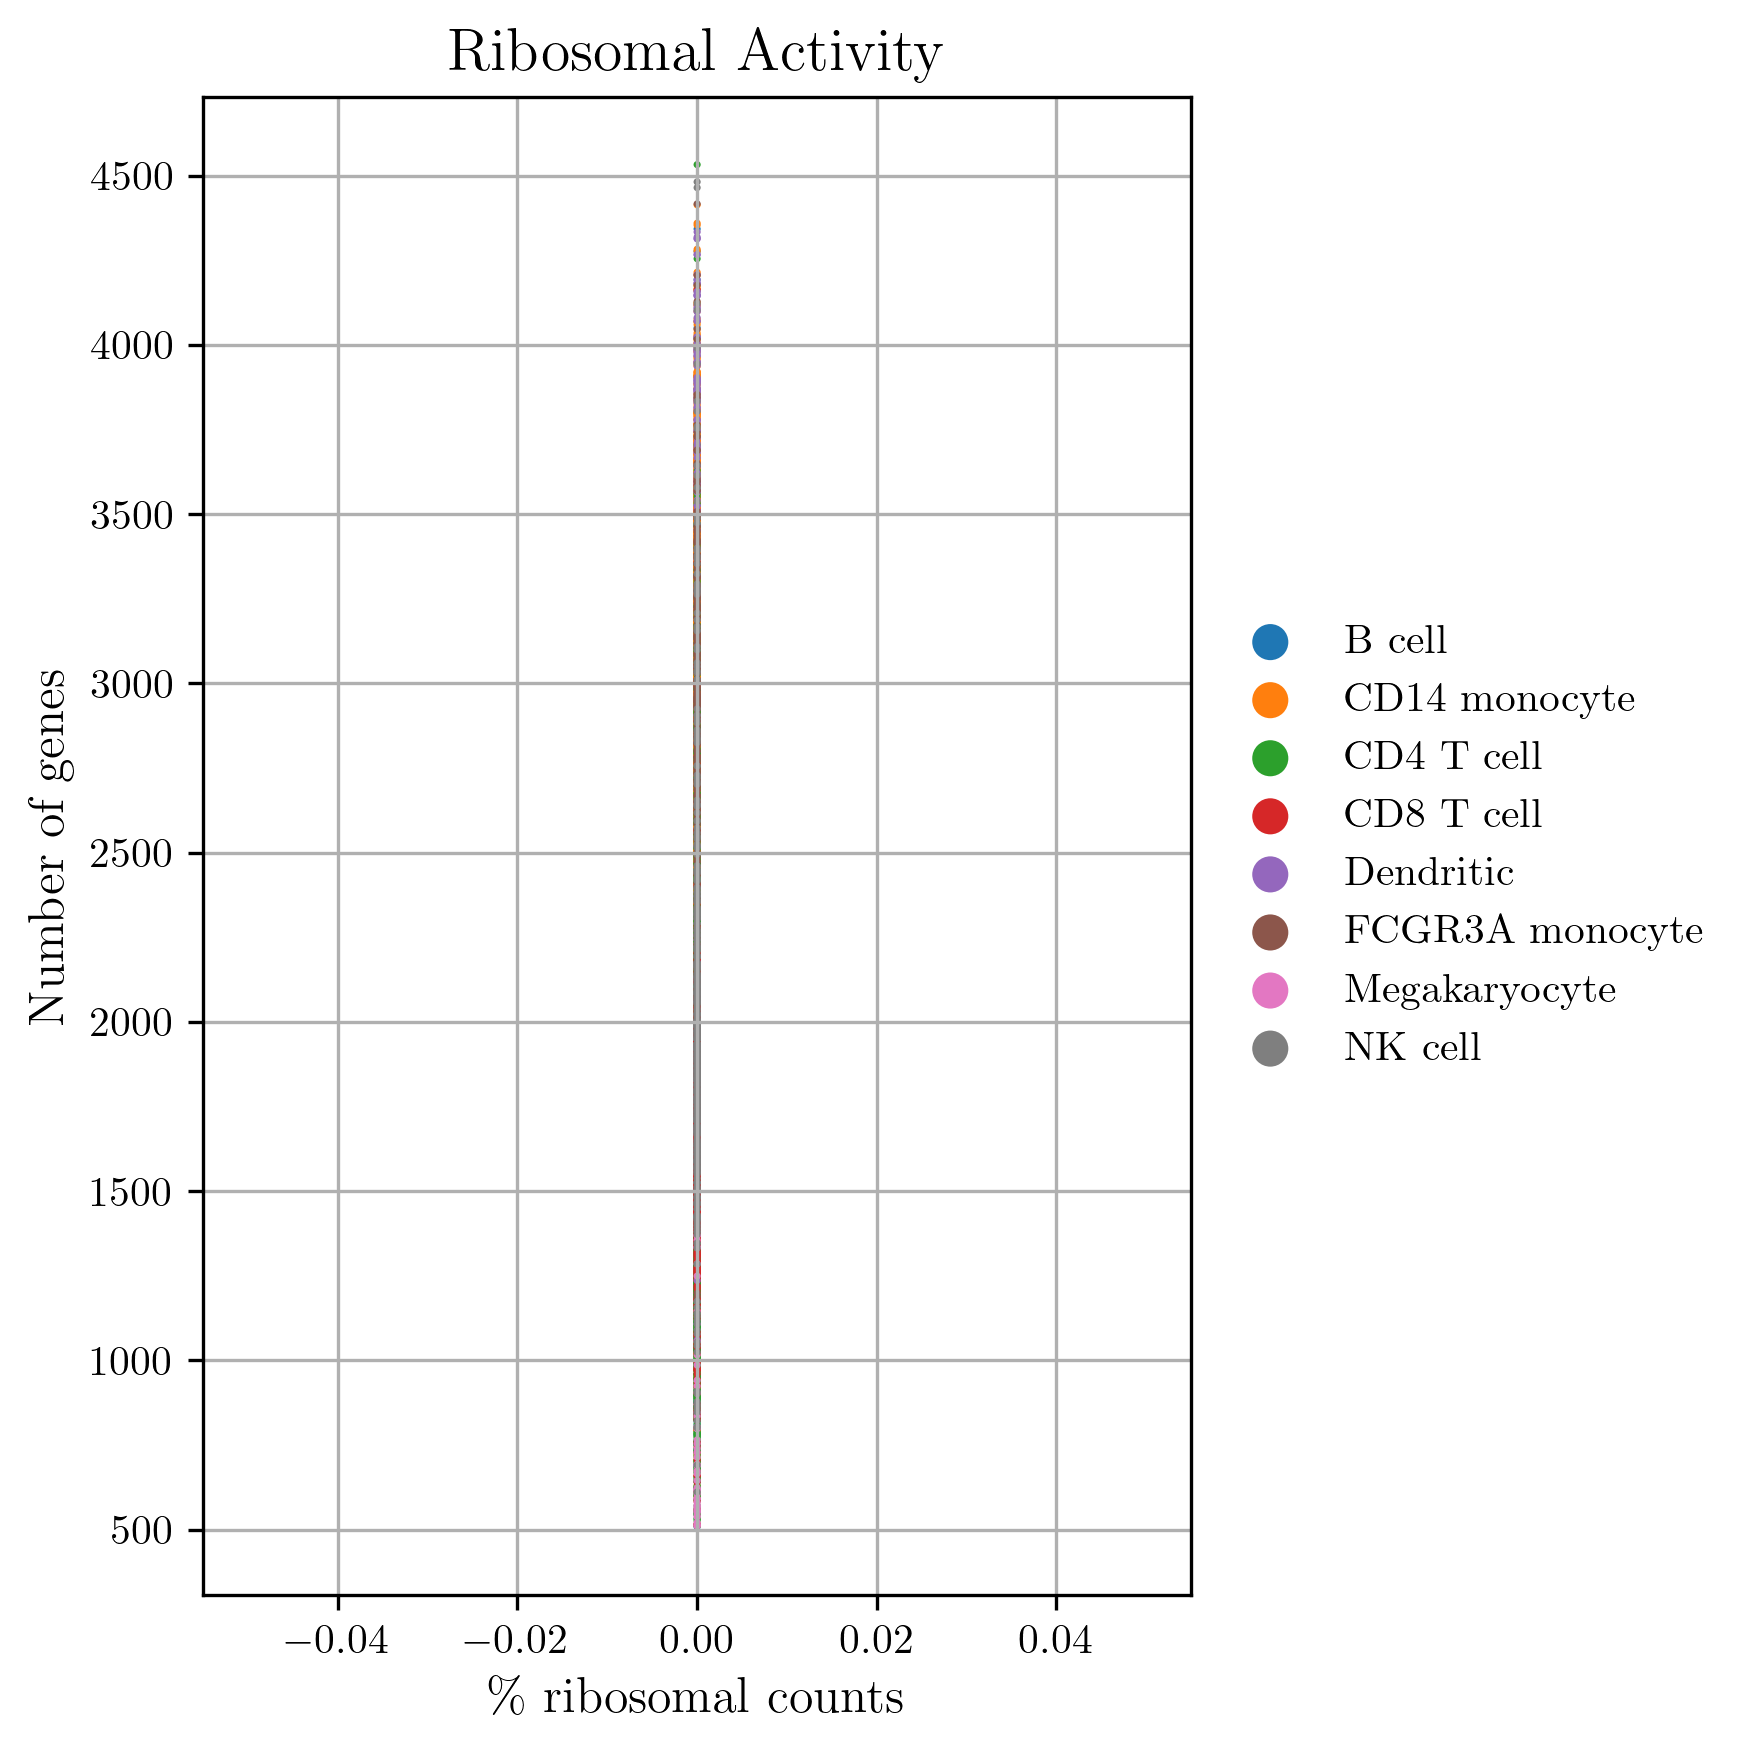

In [13]:
# import and clean up data

cna_bench = sc.read_h5ad('PBMC_simulated_cnas_041025.h5ad')
cna_bench.var_names_make_unique()

# quality control
cna_bench.var['mt'] = cna_bench.var_names.str.startswith('MT-')   # filtering to keep genes expressed in mitochondria
ribo_prefix = ('RPS','RPL')
cna_bench.var['ribo'] = cna_bench.var_names.str.startswith(ribo_prefix)   # filtering to keep genes expressed in ribosomes
sc.pp.calculate_qc_metrics(cna_bench, qc_vars=['mt', 'ribo'], percent_top = None, log1p = False, inplace = True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,4), gridspec_kw = {'wspace':0.25}, constrained_layout = True)
ax1_dict = sc.pl.scatter(cna_bench, x = 'total_counts', y = 'pct_counts_mt', ax = ax1, show = False)
ax2_dict = sc.pl.scatter(cna_bench, x = 'total_counts', y = 'n_genes_by_counts', ax = ax2, show = False)
ax3_dict = sc.pl.scatter(cna_bench, x = 'pct_counts_ribo', y = 'n_genes_by_counts', ax = ax3, show = False)
plt.show()
# to visualize distribution of genes to determine how to filter them

sc.pp.filter_cells(cna_bench, min_genes = 500)   # min amount of genes shown on plots #2 and 3
sc.pp.filter_cells(cna_bench, max_counts = 15000)  # where total_counts starts to trail off
sc.pp.filter_genes(cna_bench, min_cells = 3)   # to limit to not have too many rare/unnecessary samples

# normalization
cna_benchnorm = cna_bench.copy()
cna_benchnorm.layers['counts'] = cna_benchnorm.X.copy()
sc.pp.normalize_total(cna_benchnorm, target_sum = 1e4)
sc.pp.log1p(cna_benchnorm)
cna_benchnorm.layers['lognorm'] = cna_benchnorm.X.copy()

# highly variable genes
sc.pp.highly_variable_genes(cna_benchnorm, min_mean = 0.0125, max_mean = 6, min_disp = 0.25)

# principal component analysis
sc.tl.pca(cna_benchnorm, mask_var = 'highly_variable')
sc.pl.pca_variance_ratio(cna_benchnorm, 50)
n_neighbors = 10
n_pcs = 15  # set n_pcs = 15 because this is where asymptote flattens


# ensure relevant metadata is available
if 'cell_type' not in cna_bench.obs.columns:
    print("Warning: 'cell_type' not found in .obs; fallback to default coloring")
    color = None
else:
    color = 'cell_type'

# --- Plot 1: Mitochondrial Percent vs Total Counts ---
fig, ax1 = plt.subplots(figsize=(6, 6))
sc.pl.scatter(
    cna_bench, x='total_counts', y='pct_counts_mt',
    color=color, ax=ax1, show=False, title='Mitochondrial Content'
)
ax1.set_xlabel(r'Total counts per cell')
ax1.set_ylabel(r'$\%$ mitochondrial counts')
ax1.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Total Counts vs Number of Genes (Square, Detailed) ---
fig, ax2 = plt.subplots(figsize=(8, 8))
sc.pl.scatter(
    cna_bench, x='total_counts', y='n_genes_by_counts',
    color=color, ax=ax2, show=False, title='Gene Complexity'
)
ax2.set_xlabel(r'Total counts per cell')
ax2.set_ylabel(r'Number of genes')
ax2.set_box_aspect(1)  # Ensures square axis box
ax2.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 3: Ribosomal Percent vs Number of Genes ---
fig, ax3 = plt.subplots(figsize=(6, 6))
sc.pl.scatter(
    cna_bench, x='pct_counts_ribo', y='n_genes_by_counts',
    color=color, ax=ax3, show=False, title='Ribosomal Activity'
)
ax3.set_xlabel(r'$\%$ ribosomal counts')
ax3.set_ylabel(r'Number of genes')
ax3.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# import and clean up data
# https://datasets.cellxgene.cziscience.com/37bad2b9-ed30-4070-a19c-b94df1e6758a.h5ad; https://doi.org/10.1016/j.cell.2025.02.017

data1 = sc.read_h5ad('')
data1.var_names_make_unique()

# quality control
data1.var['mt'] = data1.var_names.str.startswith('MT-')   # filtering to keep genes expressed in mitochondria
ribo_prefix = ('RPS','RPL')
data1.var['ribo'] = data1.var_names.str.startswith(ribo_prefix)   # filtering to keep genes expressed in ribosomes
sc.pp.calculate_qc_metrics(data1, qc_vars=['mt', 'ribo'], percent_top = None, log1p = False, inplace = True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,4), gridspec_kw = {'wspace':0.25}, constrained_layout = True)
ax1_dict = sc.pl.scatter(data1, x = 'total_counts', y = 'pct_counts_mt', ax = ax1, show = False)
ax2_dict = sc.pl.scatter(data1, x = 'total_counts', y = 'n_genes_by_counts', ax = ax2, show = False)
ax3_dict = sc.pl.scatter(data1, x = 'pct_counts_ribo', y = 'n_genes_by_counts', ax = ax3, show = False)
plt.show()
# to visualize distribution of genes to determine how to filter them

sc.pp.filter_cells(data1, min_genes = 100)   # min amount of genes shown on plots #2 and 3
sc.pp.filter_cells(data1, max_counts = 3000)  # where total_counts starts to trail off
sc.pp.filter_genes(data1, min_cells = 3)   # to limit to not have too many rare/unnecessary samples

# normalization
data1norm = data1.copy()
data1norm.layers['counts'] = data1norm.X.copy()
sc.pp.normalize_total(data1norm, target_sum = 1e4)
sc.pp.log1p(data1norm)
data1norm.layers['lognorm'] = data1norm.X.copy()

# highly variable genes
sc.pp.highly_variable_genes(data1norm, min_mean = 0.0125, max_mean = 6, min_disp = 0.25)

# principal component analysis
sc.tl.pca(data1norm, mask_var = 'highly_variable')
sc.pl.pca_variance_ratio(data1norm, 50)
n_neighbors = 10
n_pcs = 20  # set n_pcs = 20 because this is where asymptote flattens

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/ColabNotebooks/final/data1_?.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

#**Project tasks.**

**Task 1: Create a method that infers CNAs from scRNA-seq data**

Write a Python package that allows users to define the genotype and genomic region of CNAs from scRNA-seq data. Genotype in this case can be either 'gain' or 'loss'. The minimal input is an annData object that contains raw expression counts of genes that are named in the .var slot across the cells listed in the .obs slot. The output should be:

*   a list of CNAs where each CNA is defined by genomic region (chromosome, start, stop,) and some indication of the type of CNA (e.g. 'gain' | loss')

*   an assignment of CNAs to cells, or to groups of cells.

Other requirements:

*   The method must be written in Python
*   The code must be housed at GitHub
*   The code must be organized following Python package conventions. See this tutorial as a guide. Note that you do not have to upload it to PyPI.
*   Your repo must contain documentation that describes how to install your package and how to use it. The easiest place to put this information is in a README.md file.

**A1.** This method is novel because ???

In [ ]:
!pip install requests_cache
import requests_cache
requests_cache.install_cache('ensembl_cache', backend = 'sqlite', expire_after = 3600)  # maintain cache for 1 hour

base_url = "https://rest.ensembl.org/lookup/id/"

map_genes = {'gene': [], 'chrom': [], 'start': [], 'end': []}
for i in data1.var.index.tolist():
  gene_id = i
  ensembl_url = f"{base_url}{gene_id}?content-type=application/json"

  with requests_cache.CachedSession() as session:
    response = requests.get(ensembl_url)  # WARNING: THIS CODE BLOCK TAKES > 2 HOURS TO RUN THROUGH WHOLE DATA SET
    if response.status_code == 200:
      gene_info = response.json()

      chromosome = gene_info['seq_region_name']
      start = gene_info['start']
      end = gene_info['end']
    else:
      print(f"Error: Could not retrieve data for {gene_id}")

      chromosome = None
      start = None
      end = None

  map_genes['gene'].append(gene_id)
  map_genes['chrom'].append(chromosome)
  map_genes['start'].append(start)
  map_genes['end'].append(end)

Error: Could not retrieve data for ENSG00000223458
Error: Could not retrieve data for ENSG00000236714


KeyboardInterrupt: 

In [ ]:
data1.var

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
ENSG00000119048,False,UBE2B_ENSG00000119048,NCBITaxon:9606,gene,669,protein_coding,False,False,32163,0.571429,51.017331,37521.308594,26919
ENSG00000162852,False,CNST_ENSG00000162852,NCBITaxon:9606,gene,2594,protein_coding,False,False,5899,0.079652,91.016113,5230.132324,4562
ENSG00000265787,False,CYP4F35P_ENSG00000265787,NCBITaxon:9606,gene,390,transcribed_unprocessed_pseudogene,False,False,145,0.002290,99.779172,150.391068,98
ENSG00000185052,False,SLC24A3_ENSG00000185052,NCBITaxon:9606,gene,3922,protein_coding,False,False,406,0.006212,99.381682,407.896881,351
ENSG00000263006,False,ROCK1P1_ENSG00000263006,NCBITaxon:9606,gene,549,transcribed_unprocessed_pseudogene,False,False,60,0.000712,99.908623,46.761639,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000103966,False,EHD4_ENSG00000103966,NCBITaxon:9606,gene,4216,protein_coding,False,False,13319,0.175073,79.715817,11495.611328,10100
ENSG00000120057,False,SFRP5_ENSG00000120057,NCBITaxon:9606,gene,1883,protein_coding,False,False,104,0.001117,99.841613,73.316101,98
ENSG00000181626,False,ANKRD62_ENSG00000181626,NCBITaxon:9606,gene,4290,protein_coding,False,False,169,0.003957,99.742621,259.803802,154
ENSG00000165025,False,SYK_ENSG00000165025,NCBITaxon:9606,gene,4936,protein_coding,False,False,11288,0.131464,82.808931,8632.172852,8810


In [ ]:
map_genes_df = pd.DataFrame(map_genes, index = map_genes['gene'])
#adata_obs_merged = pd.merge(data1.var, map_genes, left_index = True, right_index = True, how = 'left')

print(map_genes_df)

In [ ]:
# old code

In [ ]:
# define genotype and genomic region of CNAs
'''
def find_genotypes(adata, cnv_colname):
  # get list of data
  cnalist = adata.obs[cnv_colname].tolist()

  # make empty list to hold results
  cnv_list_sing = []
  cnv_list_doub = []

  # process each entry in the list
  for i in cnalist:

    if ',' not in i:
      if i == '':
        cnv_list_sing.append((None, None, None, None))
        cnv_list_doub.append((None, None, None, None))
        continue

      # split at : between chromosome and start
      chromosome_part, rest = i.split(':')
      chromosome = chromosome_part

      # split at - between start and stop
      range_part, cn_part = rest.split(' (CN ')
      cn = int(cn_part[:-1])  # remove the closing parenthesis
      start, stop = map(int, range_part.split('-'))

      # determine genotype
      if cn > 2:
        genotype = 'gain'
      elif cn == 2:
        genotype = 'none'
      else:
        genotype = 'loss'

      # append the result as a tuple to the list
      cnv_list_sing.append((chromosome, start, stop, genotype))
      cnv_list_doub.append((None, None, None, None))

    if ',' in i:
      # split at , between CNVs
      first, second = i.split(',')

      # split at : between chromosome and start
      chromosome_part1, rest1 = first.split(':')
      chromosome_part2, rest2 = second.split(':')
      chromosome1 = chromosome_part1
      chromosome2 = chromosome_part2

      # split at - between start and stop
      range_part1, cn_part1 = rest1.split(' (CN ')
      range_part2, cn_part2 = rest2.split(' (CN ')
      cn1 = int(cn_part1[:-1])  # remove the closing parenthesis
      cn2 = int(cn_part2[:-1])  # remove the closing parenthesis
      start1, stop1 = map(int, range_part1.split('-'))
      start2, stop2 = map(int, range_part2.split('-'))

      # determine genotype
      if cn1 > 2:
        genotype1 = 'gain'
      elif cn1 == 2:
        genotype1 = 'none'
      else:
        genotype1 = 'loss'

      if cn2 > 2:
        genotype2 = 'gain'
      elif cn2 == 2:
        genotype2 = 'none'
      else:
        genotype2 = 'loss'

      # append the result as a tuple to the list
      cnv_list_sing.append((chromosome1, start1, stop1, genotype1))
      cnv_list_doub.append((chromosome2, start2, stop2, genotype2))

  return cnv_list_sing, cnv_list_doub
  '''

In [ ]:
# adding CNA data to adata object
'''
def add_cnv_data(adata, cnv_list):
  adata.obs['CNA_chromosome_first'] = [i[0] for i in cnv_list[0]]
  adata.obs['CNA_start_first'] = [i[1] for i in cnv_list[0]]
  adata.obs['CNA_stop_first'] = [i[2] for i in cnv_list[0]]
  adata.obs['CNA_genotype_first'] = [i[3] for i in cnv_list[0]]

  adata.obs['CNA_chromosome_second'] = [i[0] for i in cnv_list[1]]
  adata.obs['CNA_start_second'] = [i[1] for i in cnv_list[1]]
  adata.obs['CNA_stop_second'] = [i[2] for i in cnv_list[1]]
  adata.obs['CNA_genotype_second'] = [i[3] for i in cnv_list[1]]

  return adata
  '''

In [ ]:
# map CNAs to cell types
'''
def cna_to_cell(adata, cnv_list):
  total_cells_per_cluster = adata.obs['cell_type'].value_counts().sort_index()
  cna_positive = adata.obs[adata.obs['simulated_cnvs'].notna() & (adata.obs['simulated_cnvs'] != '')]
  cna_counts = cna_positive.groupby('cell_type')['simulated_cnvs'].value_counts().unstack().fillna(0)
  fraction_by_cluster = cna_counts.div(total_cells_per_cluster, axis=0).fillna(0)
  valid_cols = [col for col in fraction_by_cluster.columns if pd.notna(col) and col != '']
  fraction_by_cluster = fraction_by_cluster[valid_cols]

  ax = fraction_by_cluster.plot(kind = 'bar', stacked = True)
  ax.legend(loc = 'best', title = 'CNA', fontsize = 'x-small')
  plt.ylabel('Fraction of All Cells')
  plt.title('CNA by Cluster (Normalized to All Cells, Excludes No CNV)')
  plt.tight_layout()
  plt.show()
  '''

**Task 2: Assessment**

Apply your method to the test data that we provided. Analze your method's performance in terms of standard metrics such as accuracy, or area under precision recall curves. If your method scores CNAs to reflect confidence in their prediction, then also evaluate this aspect. If your method has tunable parameters, then evaluate its performance across a well-justified range of parameter value combinations.

Other requirements:

*   Explore the impact of read depth on your method's performance. Scanpy has functions for down-sampling
*   Notebooks that document this task's analysis must be included in your GitHub repo



do we want to do the EC? details are on the cscb website

**A2.**

**Task 3: Measure CNA in PSCs**

Now that you have developed and assessed your method, it is time to use it! Take a look at the list of PSC scRNA-seq data below. Find an optimal subset of these datasets to see if you can infer previously reported PSC CNAs and to discover new ones.

Things to consider:

*   You do not have to analyze all of these data sets
*   You may analyze other data sets that you find as long as they are either human PSCs or their derivatives
*   You may need to integrate data across studies to infer CNAs that are cell line specific

Other requirements: * Notebooks that document this task's analysis must be included in your GitHub repo

**A3.**

**Task 4: Predict CNA impact (extra credit)**

Devise and apply a method to predict the functional impact on PSCs of CNAs in catalog that you generated in Task 3.

Other requirements: * Notebooks that document this task's analysis must be included in your GitHub repo

**A4.**